In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tf

import sys
sys.path.append( "../2PanalysisUtils" )
#sys.path.append("/home/mursel/DriveNYU/2PanalysisUtils")
import plotconfig as pconf
import matread as mread
import funx_mk as mk
import pandas as pd
import seaborn as sns
import math

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import matplotlib.colors as mlcolors
import matplotlib.cbook as cbook
from matplotlib import cm
%config InlineBackend.figure_format = 'svg'

IMAGES_PATH = Path() / "MiscResults2"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
fieldname1 = 'SC18/220908/12odorsglom/SC18_220908_12odorsglom'
glom_session1 = mk.read_session(fieldname1)
fieldname_mt1 = 'SC18/220908/12odors/SC18_220908_12odors'
mt_session1 = mk.read_session(fieldname_mt1)

odor_responses_mt1 = mt_session1['odor_responses']
odor_list_mt1 = mt_session1['odor_list']
odor_responses1 = glom_session1['odor_responses']
odor_list1 = glom_session1['odor_list']
nodor1 = glom_session1['nodor']

Number of Stimulus Types: 25
Number of Trial per Stimulus: 3
Dimensions of single trial array (# time points by # neuron # Trial): (348, 74, 3)
Number of Stimulus Types: 25
Number of Trial per Stimulus: 8
Dimensions of single trial array (# time points by # neuron # Trial): (180, 75, 8)


In [5]:
Glom2MT_1={'Glom1':  {'ID':36, 'MTID':np.array([4,21,27])},
         'Glom2': {'ID':44, 'MTID':np.array([13,14,25,29,41])},
         'Glom4': {'ID':52, 'MTID':np.array([18,22,26,35,52,70,74])},
         'MT_responses':mt_session1['odor_responses'],
         'Glom_responses':glom_session1['odor_responses'],
         'odor_list_mt': mt_session1['odor_list'],
         'odor_list_glom': glom_session1['odor_list']}
odor_responses_mt= Glom2MT_1['MT_responses']
odor_responses_glom = Glom2MT_1['Glom_responses']
gloms = ['Glom1', 'Glom2','Glom3','Glom4']

In [6]:
cellid = np.array([4,21,27,13,14,25,29,41,18,22,26,35,52,70,74])
plt.subplots_adjust(wspace = 0.1, hspace=0.2)
cell_responses1 = np.zeros([np.size(cellid),180*np.size(Glom2MT_1["odor_list_mt"])])
cell_responses_pre1 = np.zeros([np.size(cellid), np.size(Glom2MT_1["odor_list_mt"]) * 60])
cell_responses_odor1 = np.zeros([np.size(cellid), np.size(Glom2MT_1["odor_list_mt"]) * 30])
cell_responses_post1 = np.zeros([np.size(cellid), np.size(Glom2MT_1["odor_list_mt"]) * 90])

cell_count = 0
for i,odor in enumerate(Glom2MT_1["odor_list_mt"]):
        for j,cellid_ in enumerate(cellid):
                cell_responses1[j,i*180:(i+1)*180]=np.mean(Glom2MT_1["MT_responses"][i][:,cellid_-1,:],axis=1)
                cell_responses_pre1[j, i * 60:(i + 1) * 60] = np.mean(Glom2MT_1["MT_responses"][i][0:60, cellid_ - 1, :], axis=1)
                cell_responses_odor1[j, i * 30:(i + 1) * 30] = np.mean(Glom2MT_1["MT_responses"][i][60:90, cellid_ - 1, :], axis=1)
                cell_responses_post1[j, i * 90:(i + 1) * 90] = np.mean(Glom2MT_1["MT_responses"][i][90:180, cellid_ - 1, :], axis=1)



<Figure size 640x480 with 0 Axes>

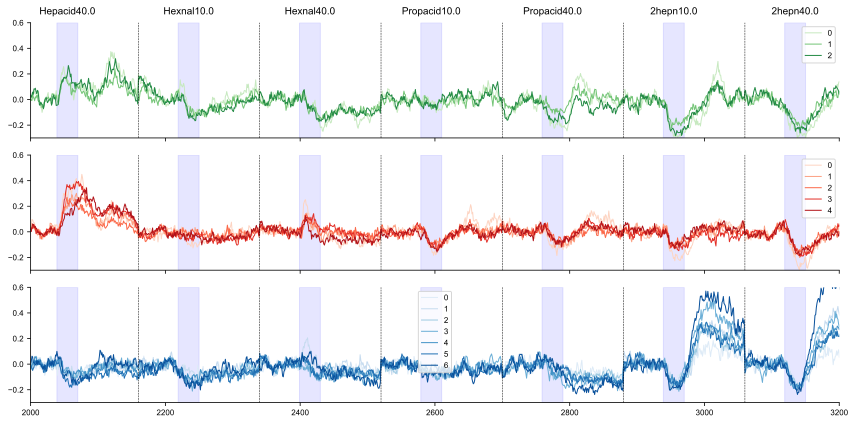

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as patches

def plot_cell_responses(cell_responses, row_groups, palettes, odors, ylim, xlim=[], patch_range=(59, 90), step=180):
    """
    Plots cell responses with patches, vertical trial lines, and odor labels above patches.

    Parameters:
    - cell_responses: numpy array containing the cell response data.
    - row_groups: List of arrays, where each array contains the indices of the rows to plot on each subplot.
    - palettes: List of color palettes for each subplot.
    - odors: List of odor names to label above each patch.
    - ylim: Tuple (min, max) for y-axis limits.
    - xlim: Tuple (min, max) for x-axis limits.
    - patch_range: Tuple (start, end) defining the start and end positions of each patch (default is (60, 90)).
    - step: Integer defining the step size for repeating patches and trial lines (default is 180).
    """

    fig, axes = plt.subplots(nrows=len(row_groups), ncols=1, figsize=[12, 2*len(row_groups)], sharex='col', sharey='col')

    # Define start and end positions for the patches
    patch_starts = np.arange(patch_range[0], np.size(cell_responses[0, :]), step)
    patch_width = patch_range[1] - patch_range[0]

    # Define trial lines (starting every 'step' units)
    trial_lines = np.arange(0, np.size(cell_responses[0, :]), step)

    # Loop over each row group and corresponding subplot
    for i, group in enumerate(row_groups):
        sns.lineplot(data=cell_responses[group, :].T, ax=axes[i], palette=palettes[i], dashes=False, lw=1.0)

        # Add patches and odor names to the subplot
        for j, start in enumerate(patch_starts):
            # Add patch
            patch = patches.Rectangle((start, ylim[0]), patch_width, ylim[1] - ylim[0], color='blue', alpha=0.1)
            axes[i].add_patch(patch)

            # Add odor name label only on the first row
            if i == 0 and j < len(odors):
                # Use the x-coordinate based on the current axes limits
                x_position = start + patch_width / 2

                # Only place the text if within xlim range
                if xlim:
                    if x_position >= xlim[0] and x_position <= xlim[1]:
                        axes[i].text(x_position, ylim[1] + 0.05, odors[j], ha='center', va='bottom', fontsize=10, color='black')

        # Add trial lines
        axes[i].vlines(trial_lines, ymin=ylim[0], ymax=ylim[1], lw=0.5, color='k', linestyles='--')

        # Style the plot (remove top and right spines)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        # Set axis limits
        axes[i].set_ylim(ylim)
        if xlim:
            axes[i].set_xlim(xlim)

    plt.tight_layout()
    plt.show()
    return fig, axes

# Example usage
row_groups = [np.array([0, 1, 2]), np.array([3, 4, 5, 6, 7]), np.array([8, 9, 10, 11, 12, 13, 14])]
palettes = ['Greens', 'Reds', 'Blues']
ylim = (-0.3, 0.6)
xlim = (2000, 3200)

fig, _ = plot_cell_responses(cell_responses1, row_groups, palettes, odor_list_mt1, ylim, xlim)
pconf.save_fig("SC18_220908_SisterCells", fig=fig, fig_extension='pdf', tight_layout=False, Imagespath=IMAGES_PATH)


In [8]:
fieldname_mt1 = 'SC18/220628/13odors/SC18_220628_field1test'
mt_session2 = mk.read_session(fieldname_mt1)

odor_responses_mt2 = mt_session2['odor_responses']
odor_list_mt2 = mt_session2['odor_list']
nodor2= mt_session2['nodor']

In [9]:
Glom2MT={'Glom1':  {'ID':26, 'MTID':np.array([6,15,31,32])},
         'Glom2': {'ID':38, 'MTID':np.array([45,57,79])},
         'Glom4': {'ID':25, 'MTID':np.array([24,42,51])},
         'Glom5': {'ID':34, 'MTID':np.array([34,49,52,65])},
         'MT_responses':odor_responses_mt2,
         'odor_list_mt': odor_list_mt2,
         'odor_list_glom': odor_list_mt2}

In [10]:
cellid = np.array([6,15,31,32,45,57,79,24,42,51,34,49,52,65])
cell_responses2 = np.zeros([np.size(cellid),180*nodor2])
cell_responses_pre2 = np.zeros([np.size(cellid), np.size(odor_list_mt2) * 60])
cell_responses_odor2 = np.zeros([np.size(cellid), np.size(odor_list_mt2) * 30])
cell_responses_post2 = np.zeros([np.size(cellid), np.size(odor_list_mt2) * 90])
cell_count = 0
for i,odor in enumerate(Glom2MT["odor_list_mt"]):
        for j,cellid_ in enumerate(cellid):
                cell_responses2[j,i*180:(i+1)*180]=np.mean(Glom2MT["MT_responses"][i][:,cellid_-1,:],axis=1)
                cell_responses_pre2[j, i * 60:(i + 1) * 60] = np.mean(Glom2MT["MT_responses"][i][0:60, cellid_ - 1, :], axis=1)
                cell_responses_odor2[j, i * 30:(i + 1) * 30] = np.mean(Glom2MT["MT_responses"][i][60:90, cellid_ - 1, :], axis=1)
                cell_responses_post2[j, i * 90:(i + 1) * 90] = np.mean(Glom2MT["MT_responses"][i][90:180, cellid_ - 1, :], axis=1)

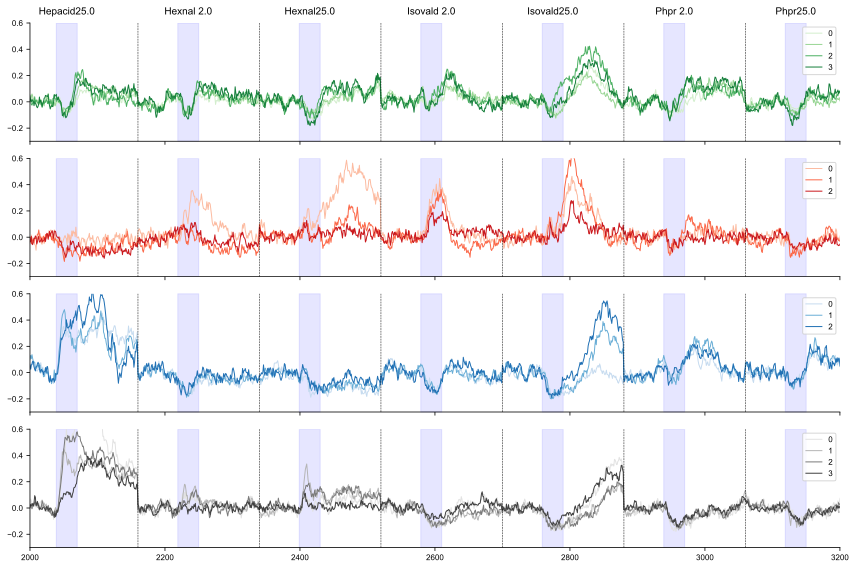

In [11]:
row_groups = [np.array([0, 1, 2,3]), np.array([4, 5, 6]), np.array([7,8, 9]), np.array([10, 11, 12, 13])]
palettes = ['Greens', 'Reds', 'Blues','Greys']
ylim = (-0.3, 0.6)
xlim = (2000, 3200)

fig, _ = plot_cell_responses(cell_responses2, row_groups, palettes,odor_list_mt2, ylim,xlim)
pconf.save_fig("SC18_220628_SisterCells",fig=fig,fig_extension = 'pdf',tight_layout=True, Imagespath = IMAGES_PATH)

In [12]:
fieldname2 = '1955/210723/10odorsstim/SC1955_210723_10odorsstim'
mt_session2 = mk.read_session(fieldname2)

In [13]:
Glom2MT_2={'Glom1':  {'ID':36, 'MTID':np.array([17,50,54,20,53])},
         'Glom2': {'ID':44, 'MTID':np.array([5,7,55])},
         'Glom3':  {'ID':46, 'MTID':np.array([38,40,2,29])},
         'MT_responses':mt_session2['odor_responses'],
         'odor_list_mt': mt_session2['odor_list']}
odor_responses_mt= Glom2MT_2['MT_responses']
gloms = ['Glom1', 'Glom2','Glom3']

In [14]:
cellid = np.array([17,50,54,20,53,5,7,55,38,40,2,29])
cell_responses3 = np.zeros([np.size(cellid),90*np.size(Glom2MT_2["odor_list_mt"])])
cell_responses_pre3 = np.zeros([np.size(cellid), np.size(Glom2MT_2["odor_list_mt"]) * 30])
cell_responses_odor3 = np.zeros([np.size(cellid), np.size(Glom2MT_2["odor_list_mt"]) * 30])
cell_responses_post3 = np.zeros([np.size(cellid), np.size(Glom2MT_2["odor_list_mt"]) * 60])
kk = 0
for i,odor in enumerate(Glom2MT_2["odor_list_mt"]):
        if i%2 ==0:
                for j,cellid_ in enumerate(cellid):
                        cell_responses3[j,kk*180:(kk+1)*180]=np.mean(Glom2MT_2["MT_responses"][i][:,cellid_-1,:],axis=1)
                        cell_responses_pre3[j, kk * 30:(kk + 1) * 30] = np.mean(Glom2MT_2["MT_responses"][i][0:30, cellid_ - 1, :], axis=1)
                        cell_responses_odor3[j, kk * 30:(kk + 1) * 30] = np.mean(Glom2MT_2["MT_responses"][i][60:90, cellid_ - 1, :], axis=1)
                        cell_responses_post3[j, kk * 60:(kk + 1) * 60] = np.mean(Glom2MT_2["MT_responses"][i][90:150, cellid_ - 1, :], axis=1)
                kk +=1

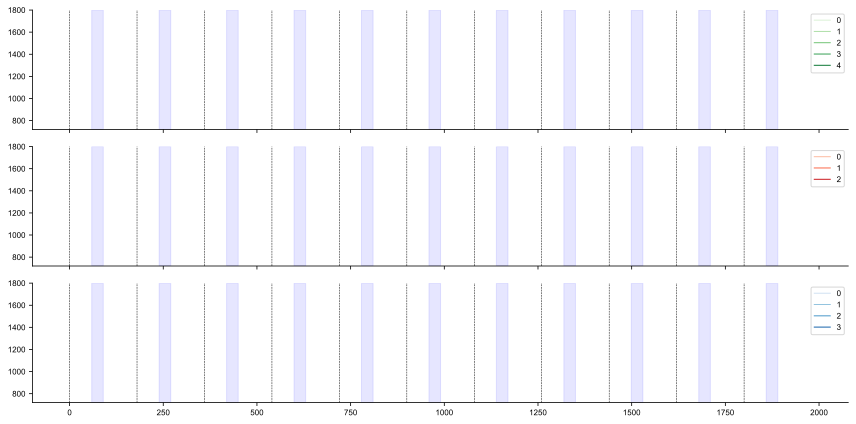

<Figure size 640x480 with 0 Axes>

In [15]:

row_groups = [np.array([0, 1, 2,3,4]), np.array([5, 6,7]), np.array([8, 9,10,11])]
palettes = ['Greens', 'Reds', 'Blues','Greys']
xlim = (720, 1800)

plot_cell_responses(cell_responses3, row_groups, palettes, ylim,xlim)
pconf.save_fig("MK1955_SisterCells",fig_extension = 'pdf',tight_layout=False, Imagespath = IMAGES_PATH)

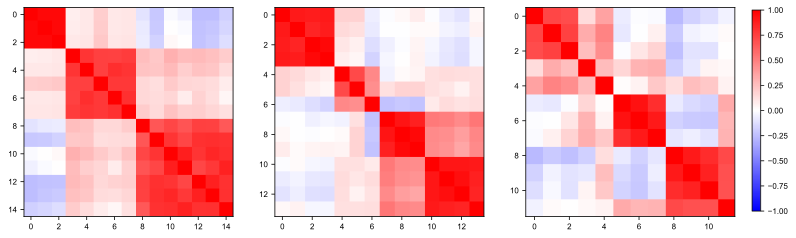

In [16]:
from sklearn.metrics import pairwise
from sklearn import metrics
fig, axes = plt.subplots(nrows =1, ncols = 3,figsize=[12, 4],sharex ='col',sharey ='col')

a = pairwise.cosine_similarity(cell_responses1)
im = axes[0].imshow(a,cmap= 'bwr',vmin=-1,vmax=1,interpolation=None)

a = pairwise.cosine_similarity(cell_responses2)
im = axes[1].imshow(a,cmap= 'bwr',vmin=-1,vmax=1,interpolation=None)
a = pairwise.cosine_similarity(cell_responses3)
im = axes[2].imshow(a,cmap= 'bwr',vmin=-1,vmax=1,interpolation=None)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
pconf.save_fig("MitralCell_CosineSimilarity",fig_extension = 'pdf',tight_layout=False, Imagespath = IMAGES_PATH)

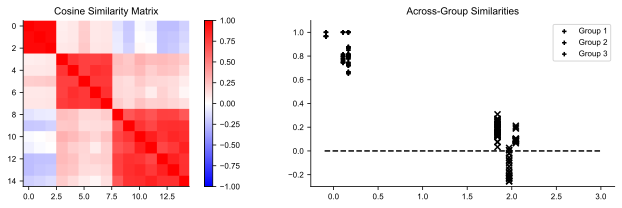

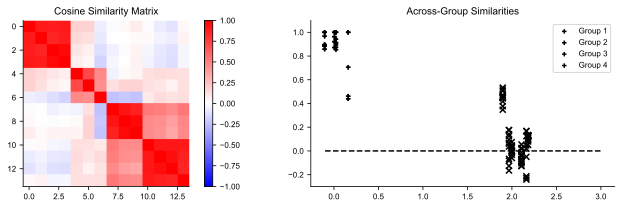

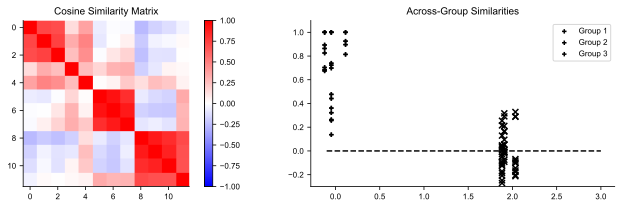

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
import seaborn as sns

# Function to plot similarities
def plot_group_similarities(cell_responses, cell_groups, axes):
    """
    Plot within-group and across-group similarities for a given set of cell responses and group assignments.

    Parameters:
    cell_responses: np.array
        Matrix of cell responses, where rows correspond to cells and columns correspond to features.
    cell_groups: list of np.array
        List of arrays, each containing indices of cells that belong to a group.
    axes: list of matplotlib axes
        List of axes to plot the full similarity matrix and group comparisons.
    """
    # Compute cosine similarity matrix
    cos_sim_matrix = pairwise.cosine_similarity(cell_responses)

    # Plot full cosine similarity matrix
    im = axes[0].imshow(cos_sim_matrix, cmap='bwr', vmin=-1, vmax=1, interpolation=None)
    axes[0].set_title('Cosine Similarity Matrix')
    plt.colorbar(im, ax=axes[0])

    # Function to get pairwise similarities for given cell groups
    def get_pairwise_similarities(group1, group2, sim_matrix):
        return sim_matrix[np.ix_(group1, group2)].flatten()

    # Plot within-group similarities
    for i, group in enumerate(cell_groups):
        within_sim = get_pairwise_similarities(group, group, cos_sim_matrix)
        axes[1].scatter(np.zeros([len(within_sim), 1]) + np.random.randn(1)*0.1, within_sim, label=f'Group {i+1}',marker='+',s=20,color='k')
    axes[1].set_title('Within-Group Similarities')
    axes[1].set_ylim([-0.5, 1.5])
    axes[1].legend()

    # Plot across-group similarities for all group pairs
    for i in range(len(cell_groups)):
        for j in range(i + 1, len(cell_groups)):
            across_sim = get_pairwise_similarities(cell_groups[i], cell_groups[j], cos_sim_matrix)
            axes[1].scatter(np.zeros([len(across_sim), 1]) + 2 + np.random.randn(1)*0.1, across_sim,marker='x',color='k')

    axes[1].set_title('Across-Group Similarities')
    axes[1].set_ylim([-0.3, 1.1])
    axes[1].hlines(0, -0.1, 3, linestyles='--', colors='k')
    sns.despine()

# Cell groups
cell_groups = [np.array([0, 1, 2]), np.array([3, 4, 5, 6, 7]), np.array([8, 9, 10, 11, 12, 13, 14])]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 3], sharex='col', sharey='col')
plot_group_similarities(cell_responses1, cell_groups, axes)


cell_groups2 =[np.array([0, 1, 2,3]), np.array([4, 5, 6]), np.array([7,8, 9]), np.array([10, 11, 12, 13])]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 3], sharex='col', sharey='col')
plot_group_similarities(cell_responses2, cell_groups2, axes)

cell_groups3 =[np.array([0, 1, 2,3,4]), np.array([5, 6,7]), np.array([8, 9,10,11])]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 3], sharex='col', sharey='col')
plot_group_similarities(cell_responses3, cell_groups3, axes)

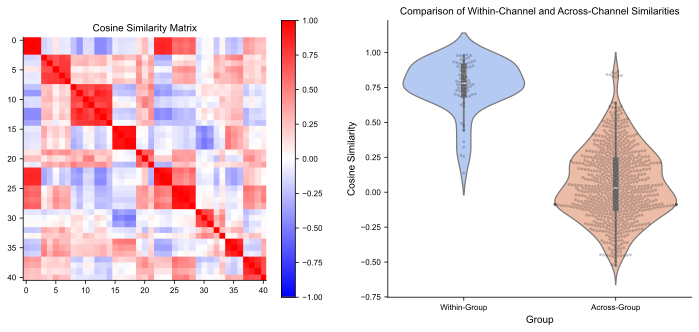

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
import seaborn as sns

def calc_group_similarities(cell_responses, cell_groups, axes):
    """
    Plot within-group and across-group similarities for a given set of cell responses and group assignments.

    Parameters:
    cell_responses: np.array
        Matrix of cell responses, where rows correspond to cells and columns correspond to features.
    cell_groups: list of np.array
        List of arrays, each containing indices of cells that belong to a group.
    axes: list of matplotlib axes
        List of axes to plot the full similarity matrix and group comparisons.
    """
    # Compute cosine similarity matrix
    cos_sim_matrix = pairwise.cosine_similarity(cell_responses)

    # Plot full cosine similarity matrix
    im = axes[0].imshow(cos_sim_matrix, cmap='bwr', vmin=-1, vmax=1, interpolation=None)
    axes[0].set_title('Cosine Similarity Matrix')
    plt.colorbar(im, ax=axes[0])

    # Function to get pairwise similarities for given cell groups, excluding self-similarities
    def get_pairwise_similarities(group1, group2, sim_matrix):
        if np.array_equal(group1, group2):
            # Extract only the upper triangle without the diagonal for within-group similarities
            mask = np.triu(np.ones((len(group1), len(group2))), k=1).astype(bool)
            return sim_matrix[np.ix_(group1, group2)][mask]
        else:
            # Extract all pairwise similarities between two different groups
            return sim_matrix[np.ix_(group1, group2)].flatten()

    # Plot within-group similarities
    within_sim = []  # Initialize as a list
    for i, group in enumerate(cell_groups):
        similarities = get_pairwise_similarities(group, group, cos_sim_matrix)
        within_sim.extend(similarities)  # Append similarities to the list

    within_sim = np.array(within_sim)  # Convert to NumPy array

    # Plot across-group similarities for all group pairs
    across_sim = []  # Initialize as a list
    for i in range(len(cell_groups)):
        for j in range(i + 1, len(cell_groups)):
            similarities = get_pairwise_similarities(cell_groups[i], cell_groups[j], cos_sim_matrix)
            across_sim.extend(similarities)
    across_sim = np.array(across_sim)  # Convert to NumPy array

    return within_sim, across_sim# Find the minimum number of features (columns) across all matrices
min_features = min(cell_responses1.shape[1], cell_responses2.shape[1], cell_responses3.shape[1])

# Trim all matrices to have the same number of features as the smallest one
cell_responses1_trimmed = cell_responses1[:, :min_features]
cell_responses2_trimmed = cell_responses2[:, :min_features]
cell_responses3_trimmed = cell_responses3[:, :min_features]

# Concatenate the trimmed matrices along the rows
cell_responses_combined = np.concatenate([cell_responses1_trimmed, cell_responses2_trimmed, cell_responses3_trimmed], axis=0)
# Adjust the cell groups based on new indices after concatenation
cell_groups_combined = [
    np.array([0, 1, 2]),  # From cell_responses1
    np.array([3, 4, 5, 6, 7]),  # From cell_responses1
    np.array([8, 9, 10, 11, 12, 13, 14]),  # From cell_responses1
    np.array([15, 16, 17, 18]),  # From cell_responses2
    np.array([19, 20, 21]),  # From cell_responses2
    np.array([22, 23, 24]),  # From cell_responses2
    np.array([25, 26, 27, 28]),  # From cell_responses2
    np.array([29,30, 31, 32,33]),  # From cell_responses3
    np.array([34,35, 36]),  # From cell_responses3
    np.array([37,38, 39,40])  # From cell_responses3

]
# Create plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 5], sharex='col', sharey='col')
within_sim, across_sim = calc_group_similarities(cell_responses_combined, cell_groups_combined, axes)

# Prepare data for plotting
data = pd.DataFrame({
    'Similarities': np.concatenate([within_sim, across_sim]),
    'Group': ['Within-Group'] * len(within_sim) + ['Across-Group'] * len(across_sim)
})
# Create violin plot with swarm plot overlay

sns.swarmplot(x='Group', y='Similarities', data=data, color='k', alpha=0.2, size=3, ax=axes[1])
sns.violinplot(x='Group', y='Similarities', data=data, palette="coolwarm", ax=axes[1])
# Set labels and title
axes[1].set_title('Comparison of Within-Channel and Across-Channel Similarities')
axes[1].set_ylabel('Cosine Similarity')
sns.despine()


pconf.save_fig("MitralCell_CosineSimilarity_Boxplot",fig_extension = 'pdf',tight_layout=False, Imagespath = IMAGES_PATH)


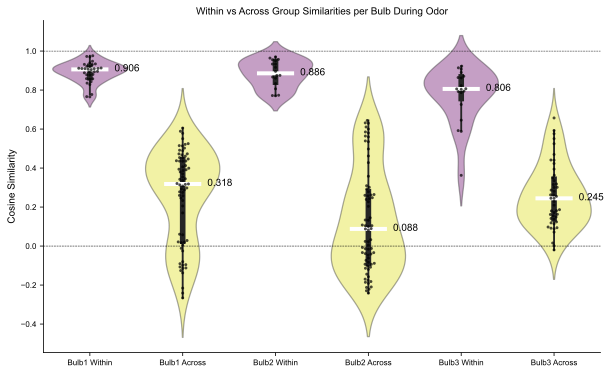

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import pairwise
import seaborn as sns

def calc_group_similarities(cell_responses, cell_groups):
    """
    Compute within-group and across-group similarities for a given set of cell responses and group assignments.

    Parameters:
    cell_responses: np.array
        Matrix of cell responses, where rows correspond to cells and columns correspond to features.
    cell_groups: list of np.array
        List of arrays, each containing indices of cells that belong to a group.

    Returns:
    within_sim: np.array
        Similarities within groups.
    across_sim: np.array
        Similarities across groups.
    """
    # Compute cosine similarity matrix
    cos_sim_matrix = pairwise.cosine_similarity(cell_responses)

    # Function to get pairwise similarities
    def get_pairwise_similarities(group1, group2, sim_matrix):
        if np.array_equal(group1, group2):
            mask = np.triu(np.ones((len(group1), len(group2))), k=1).astype(bool)
            return sim_matrix[np.ix_(group1, group2)][mask]
        else:
            return sim_matrix[np.ix_(group1, group2)].flatten()

    # Within-group
    within_sim = []
    for group in cell_groups:
        similarities = get_pairwise_similarities(group, group, cos_sim_matrix)
        within_sim.extend(similarities)

    # Across-group
    across_sim = []
    for i in range(len(cell_groups)):
        for j in range(i + 1, len(cell_groups)):
            similarities = get_pairwise_similarities(cell_groups[i], cell_groups[j], cos_sim_matrix)
            across_sim.extend(similarities)

    return np.array(within_sim), np.array(across_sim)

# ==== Now apply this to your data ====

# Assume you already have cell_responses_odor1, cell_responses_odor2, cell_responses_odor3 loaded

# Trim to the same feature dimension
min_features = min(cell_responses_odor1.shape[1], cell_responses_odor2.shape[1], cell_responses_odor3.shape[1])

cell_responses1_trimmed = cell_responses_odor1[:, :min_features]
cell_responses2_trimmed = cell_responses_odor2[:, :min_features]
cell_responses3_trimmed = cell_responses_odor3[:, :min_features]

# Define groups **relative to each Bulb's own indices**
cell_groups_Bulb1 = [
    np.array([0, 1, 2]),
    np.array([3, 4, 5, 6, 7]),
    np.array([8, 9, 10, 11, 12, 13, 14])
]
cell_groups_Bulb2 = [
    np.array([0, 1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
    np.array([10, 11, 12, 13])
]
cell_groups_Bulb3 = [
    np.array([0, 1, 2, 3, 4]),
    np.array([5, 6, 7]),
    np.array([8, 9, 10, 11])
]

# Calculate similarities for each Bulb
within1, across1 = calc_group_similarities(cell_responses1_trimmed, cell_groups_Bulb1)
within2, across2 = calc_group_similarities(cell_responses2_trimmed, cell_groups_Bulb2)
within3, across3 = calc_group_similarities(cell_responses3_trimmed, cell_groups_Bulb3)

# Prepare data for plotting
similarities = np.concatenate([within1, across1, within2, across2, within3, across3])
group_labels = (
    ['Bulb1 Within'] * len(within1) +
    ['Bulb1 Across'] * len(across1) +
    ['Bulb2 Within'] * len(within2) +
    ['Bulb2 Across'] * len(across2) +
    ['Bulb3 Within'] * len(within3) +
    ['Bulb3 Across'] * len(across3)
)

data = pd.DataFrame({
    'Similarities': similarities,
    'Group': group_labels
})

palette = {
    'Bulb1 Within': 'purple',
    'Bulb1 Across': 'yellow',
    'Bulb2 Within': 'purple',
    'Bulb2 Across': 'yellow',
    'Bulb3 Within': 'purple',
    'Bulb3 Across': 'yellow',
}

order = ['Bulb1 Within', 'Bulb1 Across', 'Bulb2 Within', 'Bulb2 Across', 'Bulb3 Within', 'Bulb3 Across']
fig, ax = plt.subplots(figsize=(10,6))
#
sns.violinplot(x='Group', y='Similarities', data=data, palette=palette, order=order, ax=ax,alpha=0.4)
sns.swarmplot(x='Group', y='Similarities', data=data, color='k', alpha=0.7, size=3, order=order, ax=ax)

group_quantiles = data.groupby('Group')['Similarities'].quantile().reindex(order)

for i, (group, mean_val) in enumerate(group_quantiles.items()):
    ax.hlines(mean_val, i-0.2, i+0.2, colors='white', linewidth=4)
    ax.text(i+0.4, mean_val-0.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10, color='black')
ax.hlines(0, -0.5, 5.5, linestyles='--', colors='k',lw=0.5)
ax.hlines(1.0, -0.5, 5.5, linestyles='--', colors='k',lw=0.5)
ax.set_xlim(-0.5, 5.5)
ax.set_title('Within vs Across Group Similarities per Bulb During Odor')
ax.set_ylabel('Cosine Similarity')
ax.set_xlabel('')
sns.despine()

# Save the figure
pconf.save_fig("MitralCell_CosineSimilarity_PerBulb", fig_extension='pdf', tight_layout=False, Imagespath=IMAGES_PATH)



In [ ]:
group_quantiles = data.groupby('Group')['Similarities'].quantile().reindex(order)
group_means

Group
Prep1 Within    0.906182
Prep1 Across    0.318439
Prep2 Within    0.885842
Prep2 Across    0.087850
Prep3 Within    0.805893
Prep3 Across    0.244776
Name: Similarities, dtype: float64

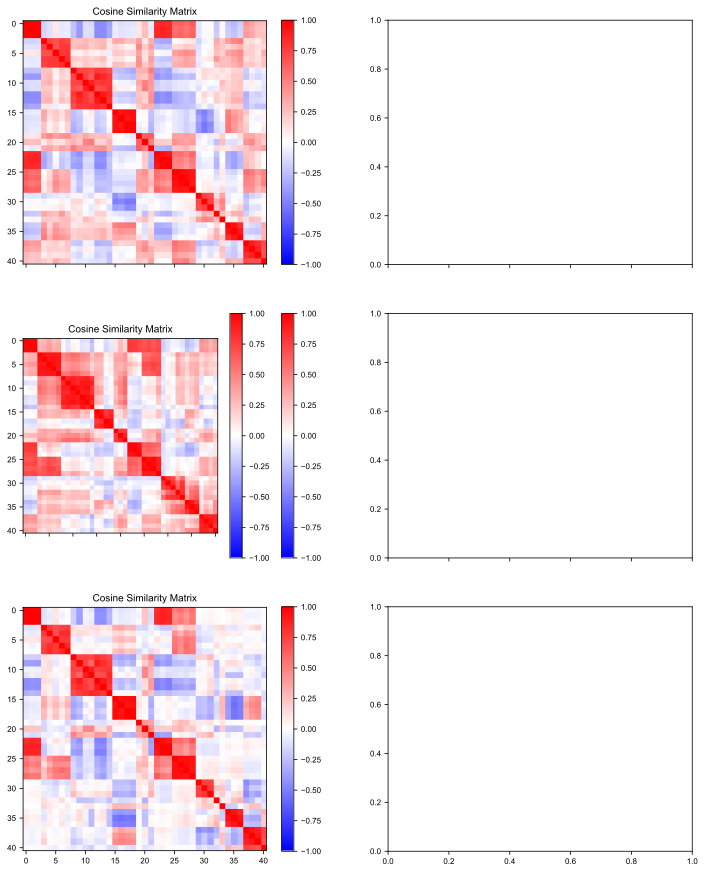

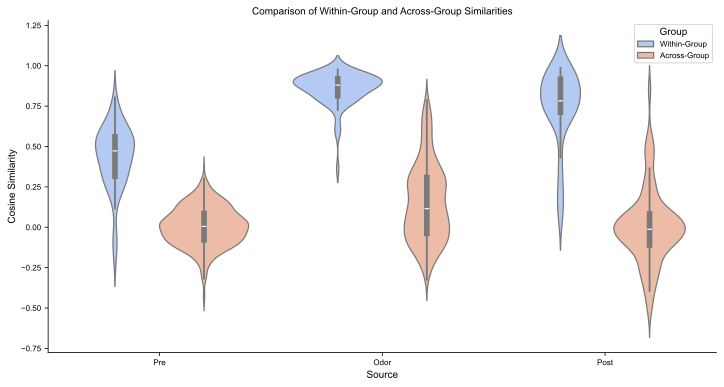

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
import seaborn as sns
import pandas as pd

def calc_group_similarities(cell_responses, cell_groups, axes):
    """
    Plot within-group and across-group similarities for a given set of cell responses and group assignments.

    Parameters:
    cell_responses: np.array
        Matrix of cell responses, where rows correspond to cells and columns correspond to features.
    cell_groups: list of np.array
        List of arrays, each containing indices of cells that belong to a group.
    axes: list of matplotlib axes
        List of axes to plot the full similarity matrix and group comparisons.
    """
    # Compute cosine similarity matrix
    cos_sim_matrix = pairwise.cosine_similarity(cell_responses)

    # Plot full cosine similarity matrix
    im = axes[0].imshow(cos_sim_matrix, cmap='bwr', vmin=-1, vmax=1, interpolation=None)
    axes[0].set_title('Cosine Similarity Matrix')
    plt.colorbar(im, ax=axes[0])

    # Function to get pairwise similarities for given cell groups, excluding self-similarities
    def get_pairwise_similarities(group1, group2, sim_matrix):
        if np.array_equal(group1, group2):
            # Extract only the upper triangle without the diagonal for within-group similarities
            mask = np.triu(np.ones((len(group1), len(group2))), k=1).astype(bool)
            return sim_matrix[np.ix_(group1, group2)][mask]
        else:
            # Extract all pairwise similarities between two different groups
            return sim_matrix[np.ix_(group1, group2)].flatten()

    # Plot within-group similarities
    within_sim = []  # Initialize as a list
    for i, group in enumerate(cell_groups):
        similarities = get_pairwise_similarities(group, group, cos_sim_matrix)
        within_sim.extend(similarities)  # Append similarities to the list

    within_sim = np.array(within_sim)  # Convert to NumPy array

    # Plot across-group similarities for all group pairs
    across_sim = []  # Initialize as a list
    for i in range(len(cell_groups)):
        for j in range(i + 1, len(cell_groups)):
            similarities = get_pairwise_similarities(cell_groups[i], cell_groups[j], cos_sim_matrix)
            across_sim.extend(similarities)
    across_sim = np.array(across_sim)  # Convert to NumPy array

    return within_sim, across_sim

# Find the minimum number of features (columns) across all matrices
min_features_all = min(cell_responses1.shape[1], cell_responses2.shape[1], cell_responses3.shape[1])
min_features_pre = min(cell_responses_pre1.shape[1], cell_responses_pre2.shape[1], cell_responses_pre3.shape[1])
min_features_odor = min(cell_responses_odor1.shape[1], cell_responses_odor2.shape[1], cell_responses_odor3.shape[1])
min_features_post = min(cell_responses_post1.shape[1], cell_responses_post2.shape[1], cell_responses_post3.shape[1])

# Trim all matrices to have the same number of features as the smallest one
cell_responses1_trimmed = cell_responses1[:, :min_features_all]
cell_responses2_trimmed = cell_responses2[:, :min_features_all]
cell_responses3_trimmed = cell_responses3[:, :min_features_all]

cell_responses_pre1_trimmed = cell_responses_pre1[:, :min_features_pre]
cell_responses_pre2_trimmed = cell_responses_pre2[:, :min_features_pre]
cell_responses_pre3_trimmed = cell_responses_pre3[:, :min_features_pre]

cell_responses_odor1_trimmed = cell_responses_odor1[:, :min_features_odor]
cell_responses_odor2_trimmed = cell_responses_odor2[:, :min_features_odor]
cell_responses_odor3_trimmed = cell_responses_odor3[:, :min_features_odor]

cell_responses_post1_trimmed = cell_responses_post1[:, :min_features_post]
cell_responses_post2_trimmed = cell_responses_post2[:, :min_features_post]
cell_responses_post3_trimmed = cell_responses_post3[:, :min_features_post]

# Concatenate the trimmed matrices along the rows
cell_responses_combined = np.concatenate([cell_responses1_trimmed, cell_responses2_trimmed, cell_responses3_trimmed], axis=0)

cell_responses_pre_combined = np.concatenate([cell_responses_pre1_trimmed, cell_responses_pre2_trimmed, cell_responses_pre3_trimmed], axis=0)
cell_responses_odor_combined = np.concatenate([cell_responses_odor1_trimmed, cell_responses_odor2_trimmed, cell_responses_odor3_trimmed], axis=0)
cell_responses_post_combined = np.concatenate([cell_responses_post1_trimmed, cell_responses_post2_trimmed, cell_responses_post3_trimmed], axis=0)

# Adjust the cell groups based on new indices after concatenation
cell_groups_combined = [
    np.array([0, 1, 2]),  # From cell_responses1
    np.array([3, 4, 5, 6, 7]),  # From cell_responses1
    np.array([8, 9, 10, 11, 12, 13, 14]),  # From cell_responses1
    np.array([15, 16, 17, 18]),  # From cell_responses2
    np.array([19, 20, 21]),  # From cell_responses2
    np.array([22, 23, 24]),  # From cell_responses2
    np.array([25, 26, 27, 28]),  # From cell_responses2
    np.array([29,30, 31, 32,33]),  # From cell_responses3
    np.array([34,35, 36]),  # From cell_responses3
    np.array([37,38, 39,40])  # From cell_responses3
]

# Create plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[12, 15], sharex='col', sharey='col')

# Compute similarities and plot them
within_sim_all, across_sim_all = calc_group_similarities(cell_responses_combined, cell_groups_combined, axes[0])
within_sim_pre, across_sim_pre = calc_group_similarities(cell_responses_pre_combined, cell_groups_combined, axes[1])
within_sim_odor, across_sim_odor = calc_group_similarities(cell_responses_odor_combined, cell_groups_combined, axes[1])
within_sim_post, across_sim_post = calc_group_similarities(cell_responses_post_combined, cell_groups_combined, axes[2])

# Prepare data for plotting
data_all = pd.DataFrame({
    'Similarities': np.concatenate([within_sim_all, across_sim_all]),
    'Group': ['Within-Group'] * len(within_sim_all) + ['Across-Group'] * len(across_sim_all),
    'Source': ['All'] * (len(within_sim_all) + len(across_sim_all))
})

data_pre = pd.DataFrame({
    'Similarities': np.concatenate([within_sim_pre, across_sim_pre]),
    'Group': ['Within-Group'] * len(within_sim_pre) + ['Across-Group'] * len(across_sim_pre),
    'Source': ['Pre'] * (len(within_sim_pre) + len(across_sim_pre))
})
data_odor = pd.DataFrame({
    'Similarities': np.concatenate([within_sim_odor, across_sim_odor]),
    'Group': ['Within-Group'] * len(within_sim_odor) + ['Across-Group'] * len(across_sim_odor),
    'Source': ['Odor'] * (len(within_sim_odor) + len(across_sim_odor))
})

data_post = pd.DataFrame({
    'Similarities': np.concatenate([within_sim_post, across_sim_post]),
    'Group': ['Within-Group'] * len(within_sim_post) + ['Across-Group'] * len(across_sim_post),
    'Source': ['Post'] * (len(within_sim_post) + len(across_sim_post))
})

# Merge the DataFrames
merged_data = pd.concat([data_pre, data_odor, data_post], ignore_index=True)

# Plotting
plt.figure(figsize=(12, 6))
sns.violinplot(x='Source', y='Similarities', hue='Group', data=merged_data, palette="coolwarm")
plt.title('Comparison of Within-Group and Across-Group Similarities')
plt.ylabel('Cosine Similarity')
sns.despine()

pconf.save_fig("MitralCell_CosineSimilarity_Boxplot", fig_extension='pdf', tight_layout=False, Imagespath=IMAGES_PATH)
plt.show()


In [20]:
from scipy.stats import mannwhitneyu, ttest_ind, f_oneway

# Calculate mean similarities
mean_similarities = merged_data.groupby(['Source', 'Group'])['Similarities'].mean().reset_index()
print(mean_similarities)

# Perform Mann-Whitney U and t-tests for each 'Source' condition
source_conditions = merged_data['Source'].unique()
for source in source_conditions:
    within_group = merged_data[(merged_data['Source'] == source) & (merged_data['Group'] == 'Within-Group')]['Similarities']
    across_group = merged_data[(merged_data['Source'] == source) & (merged_data['Group'] == 'Across-Group')]['Similarities']
    
    # Conduct Mann-Whitney U test for Within vs. Across groups
    if len(within_group) > 0 and len(across_group) > 0:
        u_stat, p_val = mannwhitneyu(within_group, across_group, alternative='two-sided')
        print(f"Mann-Whitney U test for {source} (Within vs Across): U-stat = {u_stat}, p-value = {p_val}")
        
        # Independent t-test for Within vs. Across (if normally distributed)
        t_stat, p_val = ttest_ind(within_group, across_group, equal_var=False)
        print(f"Independent t-test for {source} (Within vs Across): t-stat = {t_stat}, p-value = {p_val}")
    else:
        print(f"Insufficient data for {source} condition.")
        
# Comparison of Within-Group similarities between Odor and other conditions
odor_within = merged_data[(merged_data['Source'] == 'Odor') & (merged_data['Group'] == 'Within-Group')]['Similarities']
other_within = merged_data[(merged_data['Source'] == 'Post') & (merged_data['Group'] == 'Within-Group')]['Similarities']

# Conduct Mann-Whitney U test for Within-Group comparison (Odor vs Other conditions)
if len(odor_within) > 0 and len(other_within) > 0:
    u_stat_within, p_val_within = mannwhitneyu(odor_within, other_within, alternative='greater')
    print(f"Within-Group Mann-Whitney U test (Odor vs Other): U-stat = {u_stat_within}, p-value = {p_val_within}")
else:
    print("Insufficient data for Within-Group Odor vs Other comparison.")


In [21]:
from scipy.stats import mannwhitneyu, f_oneway
import statsmodels.stats.multicomp as mc

# Filter data for Within-Group only
within_group_data = merged_data[merged_data['Group'] == 'Within-Group']

# Separate the Within-Group data by Source condition
odor_within = within_group_data[within_group_data['Source'] == 'Odor']['Similarities']
pre_within = within_group_data[within_group_data['Source'] == 'Pre']['Similarities']
post_within = within_group_data[within_group_data['Source'] == 'Post']['Similarities']

# Check if all groups have data
if len(odor_within) > 0 and len(pre_within) > 0 and len(post_within) > 0:
    # Conduct a one-way ANOVA across Source conditions for Within-Group similarities
    f_stat, p_val_anova = f_oneway(odor_within, post_within)
    print(f"One-way ANOVA: F-stat = {f_stat}, p-value = {p_val_anova}")
    
    # If ANOVA is significant, run post-hoc tests to identify where differences lie
    if p_val_anova < 0.05:
        # Perform post-hoc Tukey HSD test
        posthoc = mc.pairwise_tukeyhsd(within_group_data['Similarities'], within_group_data['Source'])
        print("Post-hoc Tukey HSD results:")
        print(posthoc)
    else:
        print("No significant differences across Within-Group similarities in Source conditions.")

    # Mann-Whitney U test as alternative for pairwise comparisons
    u_stat_pre_odor, p_val_pre_odor = mannwhitneyu(pre_within, odor_within, alternative='less')
    u_stat_post_odor, p_val_post_odor = mannwhitneyu(post_within, odor_within, alternative='less')
    
    print(f"Mann-Whitney U test (Pre vs Odor): U-stat = {u_stat_pre_odor}, p-value = {p_val_pre_odor}")
    print(f"Mann-Whitney U test (Post vs Odor): U-stat = {u_stat_post_odor}, p-value = {p_val_post_odor}")
else:
    print("Insufficient data in one or more Source conditions for Within-Group comparison.")


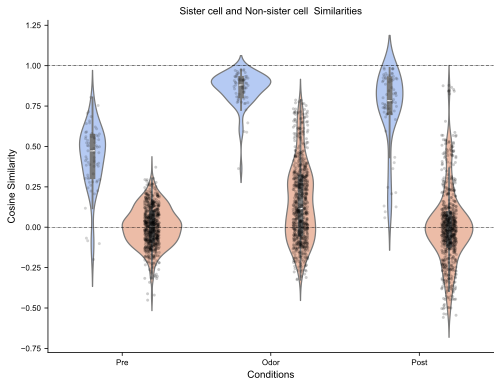

In [22]:
# Merge the DataFrames
merged_data = pd.concat([data_pre, data_odor, data_post], ignore_index=True)

# Plotting
plt.figure(figsize=(8, 6))

sns.stripplot(x='Source', y='Similarities', hue='Group', data=merged_data ,dodge=True,  alpha=0.2, size=3, jitter=0.1,color='k')
sns.violinplot(x='Source', y='Similarities', hue='Group', data=merged_data, palette="coolwarm")
plt.axhline(0, -0.5, linestyle='-.', color='k',linewidth=0.5)
plt.axhline(1, -0.5, linestyle='-.', color='k',linewidth=0.5)
plt.title('Sister cell and Non-sister cell  Similarities')
plt.ylabel('Cosine Similarity')
plt.xlabel('Conditions')
plt.legend().remove()
sns.despine()
pconf.save_fig("MitralCell_CosineSimilarity_Violinplot", fig_extension='pdf', tight_layout=False, Imagespath=IMAGES_PATH)


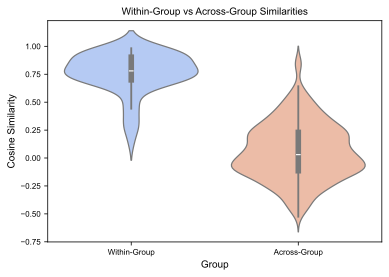

In [23]:
# Prepare data for plotting using statsmodels
import statsmodels.api as sm
from statsmodels.graphics.boxplots import violinplot
# Prepare data for plotting using seaborn
data = pd.DataFrame({
    'Similarities': np.concatenate([within_sim, across_sim]),
    'Group': ['Within-Group'] * len(within_sim) + ['Across-Group'] * len(across_sim)
})

# Plot using seaborn violin plot
plt.figure(figsize=(6, 4))
sns.violinplot(x='Group', y='Similarities', data=data, palette="coolwarm")
plt.title('Within-Group vs Across-Group Similarities')
plt.ylabel('Cosine Similarity')
plt.show()